NLP Disaster Tweets

Brief Description 

The dataset is in CSV formart and it has train.csv and test.csv.   Both CSV files have 5 columns 
1. id
2. keyword - keyword for the tweet
3. location - location of the tweet (NaN if no location was given)
4. text and - the tweet
5. target  - 1 for disaster and 0 for no disaster


the shape of the train data is - (7613, 5) meaning 7k+ rows and 5 columns.  for the test data the data is  (3263, 4), so for the test data there is no target column as we plan to predict this column.

In [53]:
#!pip install --upgrade pip
#!pip install nltk 

**EDA Procedure**

In [54]:
#import cudf as pd
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter


In [55]:
df_train = pd.read_csv("train.csv")

In [56]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [57]:
df_train.shape

(7613, 5)

In [58]:
df_test = pd.read_csv("test.csv")
df_test.shape, df_test.head()

((3263, 4),
    id keyword location                                               text
 0   0     NaN      NaN                 Just happened a terrible car crash
 1   2     NaN      NaN  Heard about #earthquake is different cities, s...
 2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
 3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
 4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan)

**EDA and visulization**

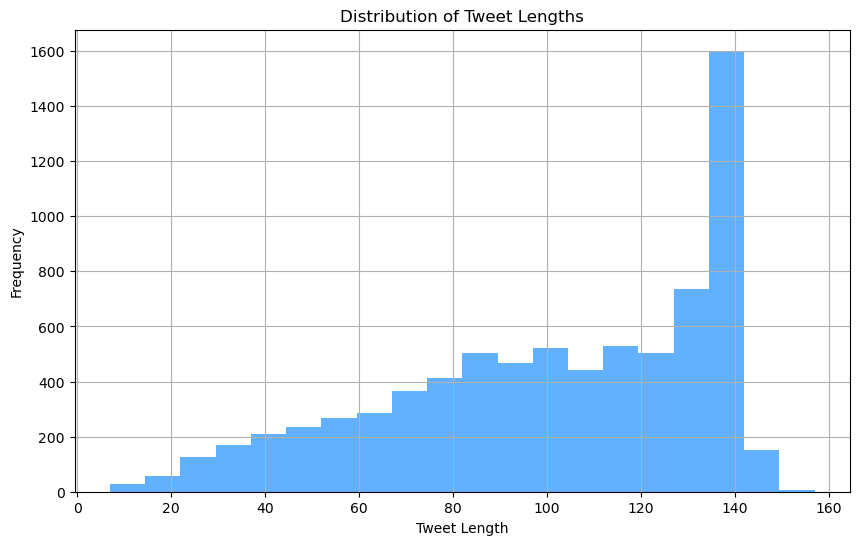

In [59]:
# Assuming 'df' is your DataFrame and 'text' is the column with tweets
df_train['tweet_length'] = df_train['text'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df_train['tweet_length'], bins=20, alpha=0.7, color='dodgerblue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

From the graph most of the tweets has a lenght of 100 characters. And majority of tweets are less than 100 characters.  The 100 characters tweets occur most frequently

In [60]:
from nltk.corpus import stopwords
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /home/olu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/olu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

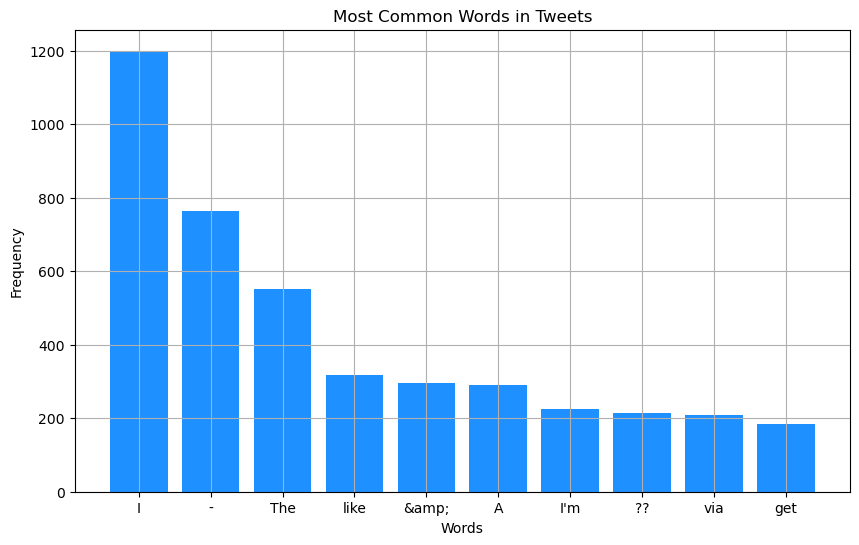

In [61]:

ps = PorterStemmer()

# Tokenize the text and remove stopwords
stopwords = set(stopwords.words('english'))
df_train['tokens'] = df_train['text'].apply(lambda x: [word for word in x.split() if word not in stopwords])

# Get the most common words
word_counts = Counter([word for tokens in df_train['tokens'] for word in tokens])
common_words = word_counts.most_common(10)

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(*zip(*common_words), color='dodgerblue')
plt.title('Most Common Words in Tweets')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Based on this histogram, the strategy is clean the data set.  Removing keywords

In [62]:
df_train['text'] = df_train['text'].str.replace('[^\w\s]', '', regex=True)

print(df_train.head())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this earthquake Ma...   
1   4     NaN      NaN              Forest fire near La Ronge Sask Canada   
2   5     NaN      NaN  All residents asked to shelter in place are be...   
3   6     NaN      NaN  13000 people receive wildfires evacuation orde...   
4   7     NaN      NaN  Just got sent this photo from Ruby Alaska as s...   

   target  tweet_length                                             tokens  
0       1            69  [Our, Deeds, Reason, #earthquake, May, ALLAH, ...  
1       1            38     [Forest, fire, near, La, Ronge, Sask., Canada]  
2       1           133  [All, residents, asked, 'shelter, place', noti...  
3       1            65  [13,000, people, receive, #wildfires, evacuati...  
4       1            88  [Just, got, sent, photo, Ruby, #Alaska, smoke,...  


**Model Building, Training, and Results**

Using pytorch, we first start with converting the words as integers into vectors.   The encoder of the transformer architecture takes the text and transforms it by understanding the relationship of the words. Then we stack multiple encoders with the transformer encoder.   The classifier layer takes the sequence of texts and passes it through to get the desired output used for classification. 

In [63]:
#USing a transformer to classify the model
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Use TransformerEncoder instead of the full Transformer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.classifier = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x


1. using the tokenizer to generate tokens 
2. Vocab Creation is used to generate the unique words 
3. Encoding is to give each unique word an integer value
4. Padding is to add zeros to the short tokens matching the longest text. 

In [64]:

tokens = [text.split() for text in df_train['text']]
vocab = Counter(word for sentence in tokens for word in sentence)
encoder = LabelEncoder()
encoder.fit(list(vocab.keys()))
encoded_texts = [encoder.transform(text) for text in tokens]
max_length = max(map(len, encoded_texts))
padded_texts = [torch.cat([torch.tensor(text), torch.zeros(max_length-len(text))]) for text in encoded_texts]
X = torch.stack(padded_texts).long()
y = torch.tensor(df_train['target'].values).float()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransformerClassifier(len(vocab), 128, 4, 2, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(texts).squeeze()
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")


Epoch 1/100, Loss: 0.682312674235299
Epoch 2/100, Loss: 0.571535957733374
Epoch 3/100, Loss: 0.5165042799180715
Epoch 4/100, Loss: 0.45447544636526654
Epoch 5/100, Loss: 0.41491231618751406
Epoch 6/100, Loss: 0.38667209477636827
Epoch 7/100, Loss: 0.3449097807806824
Epoch 8/100, Loss: 0.3194021123866136
Epoch 9/100, Loss: 0.30191652320754464
Epoch 10/100, Loss: 0.27586559959107043
Epoch 11/100, Loss: 0.25670282831366775
Epoch 12/100, Loss: 0.241353792747902
Epoch 13/100, Loss: 0.2571336469803181
Epoch 14/100, Loss: 0.24807448386755912
Epoch 15/100, Loss: 0.23115839680451997
Epoch 16/100, Loss: 0.2215278464228071
Epoch 17/100, Loss: 0.21122102724163944
Epoch 18/100, Loss: 0.201901944988061
Epoch 19/100, Loss: 0.19148085176632668
Epoch 20/100, Loss: 0.18706588096019486
Epoch 21/100, Loss: 0.18113492856397054
Epoch 22/100, Loss: 0.18062194350970354
Epoch 23/100, Loss: 0.167997310337908
Epoch 24/100, Loss: 0.16240657600744857
Epoch 25/100, Loss: 0.1590706963696717
Epoch 26/100, Loss: 0.147

In [65]:

df_test['tokens'] = df_test['text'].apply(lambda x: [word for word in x.split() if word not in stopwords])

In [66]:
df_test.head()

,id,keyword,location,text,tokens
0,0,NaN,NaN,Just happened a terrible car crash,"[Just, happened, terrible, car, crash]"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","[Heard, #earthquake, different, cities,, stay,..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond,, geese, fleeing, ac..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[Apocalypse, lighting., #Spokane, #wildfires]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[Typhoon, Soudelor, kills, 28, China, Taiwan]"


**Predict the tweets**

In [67]:
def tokenize(text, vocab, max_length):
    tokenized_text = [vocab[word] if word in vocab else vocab.get("<UNK>", 0) for word in text.split()]
    if len(tokenized_text) < max_length:
        tokenized_text += [vocab.get("<PAD>", 0)] * (max_length - len(tokenized_text))
    else:
        tokenized_text = tokenized_text[:max_length]
    return tokenized_text

test_tokenized = [tokenize(text, vocab, max_length) for text in df_test['text']]
test_tensor = torch.tensor(test_tokenized).to(device)


with torch.no_grad():
    model.eval()  
    predictions = model(test_tensor)


predicted_probs = torch.sigmoid(predictions).cpu().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)

predicted_df = pd.DataFrame({
    'id': df_test['id'],
    'target': predicted_labels.squeeze()
})
# Save the DataFrame to a CSV file
predicted_df.to_csv('predictions.csv', index=False)


The transformer solution did not produce a kaggle score greater than 0.51.  I tried different transformer hyperparamerters

**Xgboost Example**

The alternative solution was to use Xgboost to to class the data set.  First, I clean the data set, split the dataset into words. Removing all the stop words and reduce the words to root form.  Xgboost only works with numbers so I convert the text to numbers using TF-IDF.

In [68]:


def preprocess_text(text):
    word_tokens = word_tokenize(text) 
    filtered_text = [ps.stem(w) for w in word_tokens if not w in stopwords] 
    return " ".join(filtered_text)

In [69]:
df_train['text'] = df_train['text'].apply(preprocess_text)


In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_train['text'])


In [71]:
import xgboost as xgb

dtrain =xgb.DMatrix(X, label=y)
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic', 'tree_method': 'gpu_hist'}

num_round = 2
bst = xgb.train(param,dtrain, num_round)


In [72]:
test_data = vectorizer.transform(df_test['text'])
dtest = xgb.DMatrix(test_data)
predictions = bst.predict(dtest)

submission_df = pd.DataFrame({
    'id': df_test['id'],
    'target': predictions.round().astype(int)
   })
submission_df.to_csv('submission.csv', index=False)



**Xgboost Example v2**

This second example tries to imporve the perfomance of the xgboost model

In [74]:
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df_train['text'])

X = pd.concat([pd.DataFrame(X_text.toarray()), df_train[['keyword', 'location']]], axis=1)
y = df_train['target']
X=X.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ValueError: could not convert string to float: 'ablaze'

In [ ]:
le_keyword = LabelEncoder()
le_location = LabelEncoder()
df_train['keyword'] = le_keyword.fit_transform(df_train['keyword'])
df_train['location'] = le_location.fit_transform(df_train['location'])

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

param = {
    'max_depth': 6, 
    'eta': 0.3, 
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric': 'logloss', 
    'lambda': 1, # L2
    'alpha': 0.1 # L1
}

evallist = [(dtrain, 'train')]

num_round = 500 
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)


/home/olu/miniconda3/envs/rapids-23.08/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-logloss:0.66154
[1]	train-logloss:0.63636
[2]	train-logloss:0.62311
[3]	train-logloss:0.61055
[4]	train-logloss:0.59994
[5]	train-logloss:0.58725
[6]	train-logloss:0.57981
[7]	train-logloss:0.57288
[8]	train-logloss:0.56527
[9]	train-logloss:0.55870
[10]	train-logloss:0.55306
[11]	train-logloss:0.54759
[12]	train-logloss:0.54264
[13]	train-logloss:0.53770
[14]	train-logloss:0.53267
[15]	train-logloss:0.52843
[16]	train-logloss:0.52373
[17]	train-logloss:0.52024
[18]	train-logloss:0.51648
[19]	train-logloss:0.51311
[20]	train-logloss:0.50930
[21]	train-logloss:0.50518
[22]	train-logloss:0.50163
[23]	train-logloss:0.49788
[24]	train-logloss:0.49481
[25]	train-logloss:0.49091
[26]	train-logloss:0.48669
[27]	train-logloss:0.48186
[28]	train-logloss:0.47905
[29]	train-logloss:0.47616
[30]	train-logloss:0.47381
[31]	train-logloss:0.47132
[32]	train-logloss:0.46913
[33]	train-logloss:0.46655
[34]	train-logloss:0.46421
[35]	train-logloss:0.46193
[36]	train-logloss:0.45982
[37]	train-

In [ ]:
# Combine the train and test data for the 'keyword' and 'location' columns to ensure every category is seen during fitting
all_keywords = pd.concat([df_train['keyword'], df_test['keyword']]).fillna('unknown').astype(str)
all_locations = pd.concat([df_train['location'], df_test['location']]).fillna('unknown').astype(str)

# Fit the encoder
le_keyword = LabelEncoder().fit(all_keywords)
le_location = LabelEncoder().fit(all_locations)

# Now transform the train and test sets
df_train['keyword'] = le_keyword.transform(df_train['keyword'].fillna('unknown').astype(str))
df_train['location'] = le_location.transform(df_train['location'].fillna('unknown').astype(str))

df_test['keyword'] = le_keyword.transform(df_test['keyword'].fillna('unknown').astype(str))
df_test['location'] = le_location.transform(df_test['location'].fillna('unknown').astype(str))


In [ ]:
X_submit = pd.concat([pd.DataFrame(test_data.toarray()), df_test[['keyword', 'location']]], axis=1)

dsubmit = xgb.DMatrix(X_submit)
predictions_submit = bst.predict(dsubmit)
predictions_submit = [round(value) for value in predictions_submit]

submission_df = pd.DataFrame({
    'id': df_test['id'],
    'target': predictions_submit
})
submission_df.to_csv('submission_v2.csv', index=False)
